# Martindale MLND Capstone Project
## Project: Discriminating between icebergs and ships with satellite imagery

### Definition / Overview
Icebergs present a threat to ship navigation that necessitates early detection for prevention of acceidents.  Due to limitations in land and ship-based sensors, satellite radar images are among the best options for avoiding hazards in remote areas.  This project attempts to discriminate between icebergs and ships by training on image data and associated metadata.

**Note**

This project leverages data supplied as part of the Kaggle "Statoil/C-CORE Iceberg Classifier Challenge" competition.  Because the datasets approach 2GB in size, it seemed appropriate to provide references rather than provide them via upload with the proposal submission. 

You can find the [training and test datasets here](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data)

### Analysis

To properly prepare for training models, it is important to evaluate the training and test data available for the problem.  Specifically, it is necessary to evaluate the data for various shortcomings that could be addressed with preprocssing, such as:
1. Visualizing example data for intuitive signs of how the model might be able to learn
1. Looking for a balance of classes in the data
1. Ensuring that information leakage doesn't occur (possibility cited by data providers)
1. Splitting the data so that we have enough to both train and validate our models


In [2]:
import numpy as np
import pandas as pd

#Load the data.
print("Data load started...")
raw_train = pd.read_json('data/processed/train.json')
train = raw_train
print("Training data loaded...")
raw_test = pd.read_json('data/data/processed/test.json')
test = raw_test
print("Test data loaded...")

print("Done loading training & test data")

Data load started...
Training data loaded...
Test data loaded...
Done loading training & test data


In [94]:
#Reset to raw data
train = raw_train
test = raw_test
#Ensure numerical values in the inc_angle field (data provider cited 'na' values in 133 training records)
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')
test['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')
#Remove NA incident angel rows to avoid data leakeage
train = train[~train['inc_angle'].isnull()]

print("Data reset")

Data reset


### Exporatory Visualization
Below reflect example radar backscatter images of both icebergs and ships across both provided bands in the data.

In [102]:
#Collect icebergs & ships
print("Sample iceberg rows")
icebergs = train[(train['is_iceberg']==1)]
display(icebergs.head())
print("Sample ship rows")
ships =    train[(train['is_iceberg']==0)]
display(ships.head())

colormap='viridis'
#colormap='inferno'
#colormap='plasma'
#colormap='magma'

img_idx=700

Sample iceberg rows


band_1  \
2   [-24.603676, -24.603714, -24.871029, -23.15277...   
5   [-20.769371, -20.769434, -25.906025, -25.90602...   
6   [-26.673811, -23.666162, -27.622442, -28.31768...   
10  [-21.397552, -19.753859, -23.426783, -24.65221...   
12  [-21.112206, -21.638832, -25.436468, -23.22255...   

                                               band_2        id  inc_angle  \
2   [-24.870956, -24.092632, -20.653963, -19.41104...  58b2aaa0    45.2859   
5   [-29.288746, -29.712593, -28.884804, -28.88480...  b51d18b5    36.9034   
6   [-24.557735, -26.97868, -27.622442, -29.073456...  31da1a04    34.4751   
10  [-26.72291, -27.418192, -27.787899, -25.774536...  3aac67cd    44.6240   
12  [-27.30481, -28.415202999999998, -24.634125, -...  3c794f0c    41.8544   

    is_iceberg  
2            1  
5            1  
6            1  
10           1  
12           1

Sample ship rows


band_1  \
0  [-27.878360999999998, -27.15416, -28.668615, -...   
1  [-12.242375, -14.920304999999999, -14.920363, ...   
3  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  [-26.006956, -23.164886, -23.164886, -26.89116...   
7  [-24.989119, -27.755224, -25.817074, -24.98927...   

                                              band_2        id  inc_angle  \
0  [-27.154118, -29.537888, -31.0306, -32.190483,...  dfd5f913    43.9239   
1  [-31.506321, -27.984554, -26.645678, -23.76760...  e25388fd    38.1562   
3  [-27.889421, -27.519794, -27.165262, -29.10350...  4cfc3a18    43.8306   
4  [-27.206915, -30.259186, -30.259186, -23.16495...  271f93f4    35.6256   
7  [-27.755173, -26.732174, -28.124943, -31.83772...  56929c16    41.1769   

   is_iceberg  
0           0  
1           0  
3           0  
4           0  
7           0

#### Sample Iceberg Viewed in Band 1

Sample iceberg image data (band_1)


<function matplotlib.pyplot.show>

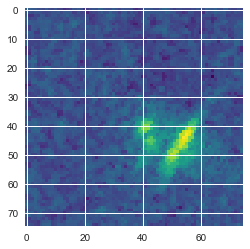

In [103]:
print("Sample iceberg image data (band_1)")
iceberg_image_band_1 = icebergs.iloc[img_idx]['band_1']
plt.imshow(np.reshape(np.array(iceberg_image_band_1),(75,75)), cmap=colormap)
plt.show

#### Sample Iceberg Viewed in Band 2

Sample iceberg image data (band_2)


<function matplotlib.pyplot.show>

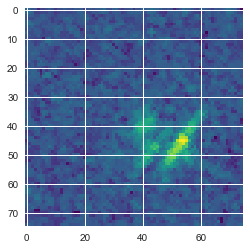

In [104]:
print("Sample iceberg image data (band_2)")
iceberg_image_band_2 = icebergs.iloc[img_idx]['band_2']
plt.imshow(np.reshape(np.array(iceberg_image_band_2),(75,75)), cmap=colormap)
plt.show

#### Sample Ship Viewed in Band 1

Sample ship image data (band_1)


<function matplotlib.pyplot.show>

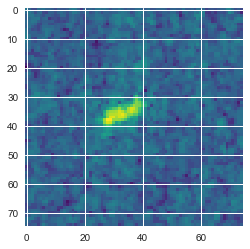

In [105]:
print("Sample ship image data (band_1)")
ship_image_band_1 = ships.iloc[img_idx]['band_1']
plt.imshow(np.reshape(np.array(ship_image_band_1),(75,75)), cmap=colormap)
plt.show

#### Sample Ship Viewed in Band 2

Sample ship image data (band_2)


<function matplotlib.pyplot.show>

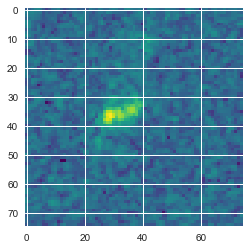

In [106]:
print("Sample ship image data (band_2)")
ship_image_band_2 = ships.iloc[img_idx]['band_2']
plt.imshow(np.reshape(np.array(ship_image_band_2),(75,75)), cmap=colormap)
plt.show

#### Impressions

While the images are far from easy to discriminate, ships appear generally more regularly shaped in the backscatter images than do the icebergs.  This likely makes sense given that ships are manmade with specific angles where icebergs form naturally, resulting in organic, irregular shapes.

Data Analysis

Training set sample data


band_1  \
0  [-27.878360999999998, -27.15416, -28.668615, -...   
1  [-12.242375, -14.920304999999999, -14.920363, ...   
2  [-24.603676, -24.603714, -24.871029, -23.15277...   
3  [-22.454607, -23.082819, -23.998013, -23.99805...   
4  [-26.006956, -23.164886, -23.164886, -26.89116...   

                                              band_2        id  inc_angle  \
0  [-27.154118, -29.537888, -31.0306, -32.190483,...  dfd5f913    43.9239   
1  [-31.506321, -27.984554, -26.645678, -23.76760...  e25388fd    38.1562   
2  [-24.870956, -24.092632, -20.653963, -19.41104...  58b2aaa0    45.2859   
3  [-27.889421, -27.519794, -27.165262, -29.10350...  4cfc3a18    43.8306   
4  [-27.206915, -30.259186, -30.259186, -23.16495...  271f93f4    35.6256   

   is_iceberg  
0           0  
1           0  
2           1  
3           0  
4           0

Test set sample data


band_1  \
0  [-15.863251, -15.201077, -17.887735, -19.17248...   
1  [-26.058969497680664, -26.058969497680664, -26...   
2  [-14.14109992980957, -15.064241409301758, -17....   
3  [-12.167478, -13.706167, -16.54837, -13.572674...   
4  [-23.37459373474121, -26.02718162536621, -28.1...   

                                              band_2        id  inc_angle  
0  [-21.629612, -21.142353, -23.908337, -28.34524...  5941774d    43.9239  
1  [-25.754207611083984, -25.754207611083984, -25...  4023181e    38.1562  
2  [-14.74563980102539, -14.590410232543945, -14....  b20200e4    45.2859  
3  [-24.32222, -26.375538, -24.096739, -23.8769, ...  e7f018bb    43.8306  
4  [-25.72234344482422, -27.011577606201172, -23....  4371c8c3    35.6256

NAs in inc_angle:  0
NAs in is_iceberg:  0
NA angle class:  Empty DataFrame
Columns: [band_1, band_2, id, inc_angle, is_iceberg]
Index: []
TRAIN band_1 min / max:  {'band_min': -45.594448, 'band_max': 34.574917}
TRAIN band_2 min / max:  {'band_min': -45.655499, 'band_max': 20.154249}
TEST band_1 min / max:  {'band_min': -45.680545806884766, 'band_max': 37.090523}
TEST band_2 min / max:  {'band_min': -49.0835, 'band_max': 37.09052276611328}
Shape:  (1471, 5)
Training Set Statistics


inc_angle   is_iceberg
count  1471.000000  1471.000000
mean     39.268707     0.511897
std       3.839744     0.500028
min      24.754600     0.000000
25%      36.106100     0.000000
50%      39.501500     1.000000
75%      42.559100     1.000000
max      45.937500     1.000000

Testing Set Statistics


inc_angle
count  1471.000000
mean     39.268707
std       3.839744
min      24.754600
25%      36.106100
50%      39.501500
75%      42.559100
max      45.937500

Check for balance
Iceberg count (is_iceberg (1)):  753
Ship count (is_iceberg (0)):  718
Done


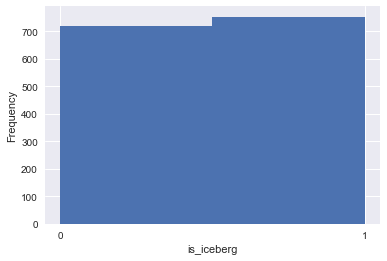

In [107]:
#Data Analysis
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Data Analysis")
print("=============")
print()
print("Training set sample data")
display(train.head())
print("Test set sample data")
display(test.head())

print("NAs in inc_angle: ", len(train[train['inc_angle'].isnull()].index))
print("NAs in is_iceberg: ", len(train[train['is_iceberg'].isnull()].index))

print("NA angle class: ", train[train['inc_angle'].isnull()].head())

def get_min_max_backscatter_db(band_data):
    temp_max = -100.0
    temp_min = 100.0
    for each_image in band_data:
        for backscatter_db in each_image:
            #print("Item: ", item)
            if backscatter_db > temp_max:
                #print("New temp_max: ", backscatter_db)
                temp_max = backscatter_db
            if backscatter_db < temp_min:
                temp_min = backscatter_db
    return {"band_min" : temp_min, "band_max" : temp_max}
    
print("TRAIN band_1 min / max: ", get_min_max_backscatter_db(train.band_1))
print("TRAIN band_2 min / max: ", get_min_max_backscatter_db(train.band_2))
print("TEST band_1 min / max: ", get_min_max_backscatter_db(test.band_1))
print("TEST band_2 min / max: ", get_min_max_backscatter_db(test.band_2))

print("Shape: ", train.shape)

print("Training Set Statistics")
display(train.describe())
#sns.displot(train.inc_angle)
print("Testing Set Statistics")
display(test.describe())

print("Check for balance")
iceberg_count = len(train[train['is_iceberg']==1].index)
ship_count = len(train[train['is_iceberg']==0].index)
print("Iceberg count (is_iceberg (1)): ", iceberg_count)
print("Ship count (is_iceberg (0)): ", ship_count)


is_iceberg_df = train['is_iceberg']
plt.figure()
plt.xticks(range(2), (0,1))
plt.xlabel('is_iceberg')
is_iceberg_df.plot.hist(2)
print("Done")

### Data Analysis Observations
Per the data analysis, there are several points that bear consideration.

#### General Observations
The image data is composed of 2 bands of radar backscatter information (one in the horizontal receive plane and one in the vertical receive plane) as well as metadata regarding the orientation of the satellite to the target when the image was taken - i.e. angle of incidence.

The radar image band data are a bit unweildy and likely require some form of normalization within the model as their values range as floats from -49 to +37.  Incidence angle, is composed of rather large float values that also may benefit from some form of normalization within the model.

#### Balance of data / classes
It is clear that icebergs are overrepresented in the training data and, as such, will need to be balanced to ensure our models don't develop a bias for one class over the other.



### Data Preprocessing
The first mandatory step is to balance the training data so that we have an equal number of the two classes, ships and icebergs.

In [109]:
#Balance the data
iceberg_count = len(train[train['is_iceberg']==1].index)
ship_count = len(train[train['is_iceberg']==0].index)
balance_amt = iceberg_count-ship_count
print("Amount to rebalance: ", balance_amt)
if(balance_amt > 0):
    iceberg_balance_sample = ((train[train['is_iceberg']==1]).sample(n=balance_amt).index)
    print(iceberg_balance_sample)

    train = train.drop(iceberg_balance_sample)
        
print("Check for balance")
print("Iceberg count (is_iceberg (1)): ", len(train[train['is_iceberg']==1].index))
print("Ship count (is_iceberg (0)): ", len(train[train['is_iceberg']==0].index))
print("Incident Angle count: ", len(train.inc_angle.index))
print("Done")

Amount to rebalance:  35
Int64Index([ 483,  634, 1069,  979,  165,  128, 1140,  536,  507, 1279,  989,
            1297,  313, 1173,  435, 1250,   74,  395,  850, 1039,  662,  988,
             320,  935,   73, 1326,  298,  118, 1258, 1032, 1367,  734,  125,
             358,  801],
           dtype='int64')
Check for balance
Iceberg count (is_iceberg (1)):  718
Ship count (is_iceberg (0)):  718
Incident Angle count:  1436
Done


The next step is to normalize the data so that it can can fit into a convolutional tensor input (i.e. 75 x 75 images with 3 channels).  In this case, we're only provided 2 channels (bands 1 & 2), so we'll create a hybrid input that is an average of the two to serve as the 3rd channel.  This 3rd channel helps facilitate other Keras / Tensor capabilities, such as use of the ImageDataGenerator for later image augmentation.

In [21]:
#Normalize/scale the data
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

display(train.inc_angle.head())
angles = train.inc_angle

#Create dual band having HH and HV (i.e. tensor depth of 2)
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#3 Channels
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
#2 Channels
#X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=-1)

labels=train["is_iceberg"]
display(labels.head())

print("Done preparing training data")

0    43.9239
1    38.1562
2    45.2859
3    43.8306
4    35.6256
Name: inc_angle, dtype: float64

0    0
1    0
2    1
3    0
4    0
Name: is_iceberg, dtype: int64

Done preparing training data


Lastly, we perform the train / test split on the data so that we maximize use of our test data while minimizing the risk of overfitting by retaining data the model has never seen for use in validation steps.

In [81]:
#Perform train test split
from sklearn.model_selection import train_test_split
random_seed = 42
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=random_seed, train_size=0.8)
Image_train = X_train_cv
image_labels = y_train_cv
Image_valid = X_valid
image_valid_labels = y_valid

Angle_train, Angle_valid, angle_labels, angle_valid_labels = train_test_split(Incident_angle, target_train, random_state=random_seed, train_size=0.8)

print("X_train_cv shape: ", X_train_cv.shape)
print("y_train_cv shape: ", y_train_cv.shape)
print("X_valid shape: ", X_valid.shape)
print("y_valid shape: ", y_valid.shape)

print("Image_train shape: ", Image_train.shape)
print("image_labels shape: ", image_labels.shape)
print("Image_valid shape: ", Image_valid.shape)
print("image_valid_labels shape: ", image_valid_labels.shape)

print("Angle_train shape: ", Angle_train.shape)
print("angle_labels shape: ", angle_labels.shape)
print("Angle_valid shape: ", Angle_valid.shape)
print("angle_valid_labels shape: ", angle_valid_labels.shape)



X_train_cv shape:  (1148, 75, 75, 3)
y_train_cv shape:  (1148,)
X_valid shape:  (288, 75, 75, 3)
y_valid shape:  (288,)
Image_train shape:  (1148, 75, 75, 3)
image_labels shape:  (1148,)
Image_valid shape:  (288, 75, 75, 3)
image_valid_labels shape:  (288,)
Angle_train shape:  (1148,)
angle_labels shape:  (1148,)
Angle_valid shape:  (288,)
angle_valid_labels shape:  (288,)


### General Model Training & Evaluation Prep
The following cells provide convenience functions for evaluating model performance (i.e. graphing the learning curve progress and specifying when to terminate training and how to identify and save the best model)

In [27]:
#Credit Dr. Jason Brownlee: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def graph_model_performance(model_name, history_data):
    # list all data in history
    print(history_data.history.keys())
    # summarize history for accuracy
    plt.plot(history_data.history['acc'])
    plt.plot(history_data.history['val_acc'])
    accuracy_model_title = model_name + ': model accuracy'
    plt.title(accuracy_model_title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history_data.history['loss'])
    plt.plot(history_data.history['val_loss'])
    loss_model_title = model_name + ': model loss'
    plt.title(loss_model_title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
print("Done")

Done


In [32]:
def get_callbacks(filepath, patience=2):
    from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
print("Done")

Done


## Implementation
In the following cells, we define the models and evaluate them.

### Basline Analogy Model

In [112]:
#My Model (simple image-only data (no angle))
def get_baseline_analogy_model(optimizer='adam', kernel_size=3, pool_size=3, strides=2, dropout_rate=0.2):
    import keras
    from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
    from keras.models import Sequential, Model
    model = Sequential()

    #Image Model
    #Conv Layer 1
    model.add(BatchNormalization(input_shape=(75,75,3)))
    model.add(Conv2D(filters=64, kernel_size=5, activation='relu', input_shape=(75,75,3)))
    model.add(MaxPooling2D(pool_size=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Conv Layer 2
    model.add(Conv2D(filters=128,kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Conv Layer 3
    model.add(Conv2D(filters=256,kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Conv Layer 4
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Flatten Layer
    model.add(Flatten())
    
    #Dense Layer 1
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    #Dense Layer 2
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    #Sigmoid Layer
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])    
    print("get_baseline_analogy_model: ", model)
    return model

print("Done")

Done


#### Evaluate the Baseline Analogy Model

Start
X_train_cv shape:  (1148, 75, 75, 3)
y_train_cv shape:  (1148,)
X_valid shape:  (288, 75, 75, 3)
y_valid shape:  (288,)
Image_train shape:  (1148, 75, 75, 3)
image_labels shape:  (1148,)
Image_valid shape:  (288, 75, 75, 3)
image_valid_labels shape:  (288,)
Angle_train shape:  (1148,)
angle_labels shape:  (1148,)
Angle_valid shape:  (288,)
angle_valid_labels shape:  (288,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_775 (Bat (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_599 (Conv2D)          (None, 71, 71, 64)        4864      
_________________________________________________________________
max_pooling2d_149 (MaxPoolin (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_776 (Bat (None, 36, 36, 64)        256       
________________________

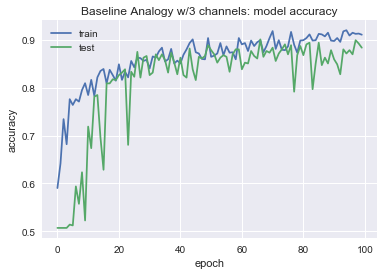

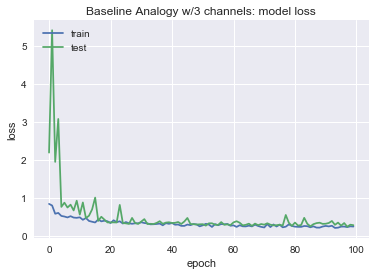

Done


In [74]:
print("Start")
try:
    import os
    os.system('say "And they are off and running!"')
    epochs = 100
    batch_size = 24

    #Generate additional augmented data
    from keras.preprocessing.image import ImageDataGenerator
    idg = ImageDataGenerator(
        width_shift_range=0.2,  #Seems intuitive the image could shift width-wise
        height_shift_range=0.2, #Seems intuitive the image could shift height-wise
        zoom_range=0.2) #Seems intuitive the image could vary in zoom  (orbit apogee/perigee)
    train_datagen = idg
    valid_datagen = idg

    train_generator = train_datagen.flow(Image_train, image_labels, batch_size=batch_size, seed=random_seed)
    validation_generator = valid_datagen.flow(Image_valid, image_valid_labels, batch_size=batch_size, seed=random_seed)
    
    simple_model = get_baseline_analogy_model()      
    #model.load_weights(filepath='saved_models/weights.best.from_first_dual_band_cnn_asof121717-738pm.hdf5')

    #My Model
    """get_my_model().fit(X_train_cv, y_train_cv, 
              validation_data=(X_valid, y_valid),
              epochs=epochs, batch_size=24, callbacks=callbacks, verbose=1)"""
    #Baseline model analogy with ImageDataGenerator normalization / augmentation
    callbacks = get_callbacks('saved_models/weights.best.from_baseline_analogy_images_only_model.hdf5', 20)
    history = simple_model.fit_generator(train_generator, 
              validation_data=validation_generator,
              epochs=epochs, steps_per_epoch=batch_size,validation_steps=batch_size, callbacks=callbacks, verbose=1)

    graph_model_performance('Baseline Analogy w/3 channels', history)
    
    print("Done")
    os.system('say "Process has finished running.  Attitude is everything!"')
    os.system('say "Process has finished running.  Attitude is everything!"')
    os.system('say "Process has finished running.  Attitude is everything!"')
except:
    os.system('say "Just a moment.  Just a moment.  I just picked up a fault in the A E 35 Unit"')
    print("ERROR OCCURED!")
    raise

### Complex Merge Model
This model incorporates both image and incidence angle data by merging the spatial and sensor metadata into a combined input for the classification layer.

In [54]:
#Build a model to incorporate incident angle (non-image/spatial) data AND radar image/spatial data

def get_complex_model():
    dropout_rate=0.4
    import keras
    from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
    from keras.models import Sequential, Model
    
    channels = 3 #TOGGLE BETWEEN 2 & 3 CHANNELS (LATTER FOR IDG/IMG AUG)
    
    #Use the Keras Functional API to define a model with multiple inputs
    #Define Unprocessed Initial Inputs
    image_input = Input(shape=(75,75,channels), name='image_input')
    angle_input = Input(shape=(1,), name='angle_input')
    
    #Image Model
    image_model = Sequential()
    #Conv Layer 1
    image_model.add(BatchNormalization(input_shape=(75,75,channels)))
    image_model.add(Conv2D(filters=64, kernel_size=5, activation='relu'))#, input_shape=(75,75,2)))
    image_model.add(MaxPooling2D(pool_size=2, padding='same'))
    image_model.add(BatchNormalization())
    image_model.add(Dropout(dropout_rate))
    #Conv Layer 2
    image_model.add(Conv2D(filters=128,kernel_size=5, activation='relu'))
    image_model.add(MaxPooling2D(pool_size=2, padding='same'))
    image_model.add(BatchNormalization())
    image_model.add(Dropout(dropout_rate))
    #Conv Layer 3
    image_model.add(Conv2D(filters=128,kernel_size=5, activation='relu'))
    image_model.add(MaxPooling2D(pool_size=5, padding='same'))
    image_model.add(BatchNormalization())
    image_model.add(Dropout(dropout_rate))
    #Conv Layer 4
    image_model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    image_model.add(MaxPooling2D(pool_size=2, padding='same'))
    image_model.add(BatchNormalization())
    image_model.add(Dropout(dropout_rate))
    #Flatten Layer
    image_model.add(Flatten())
    
    #Declare the image model output
    processed_image = image_model(image_input)
    
    #Angle Model
    #Define simple layer to process incident angle
    angle_model = Sequential()
    angle_model.add(BatchNormalization(input_shape=(1,)))
    angle_model.add(Dense(1,activation='relu'))#, input_shape=(1,)))
    #angle_model = Dense(1,activation='relu', input_shape=(1,))
    processed_angle = angle_model(angle_input)
    
    #Classification Model
    classification_model = Sequential()
    #Merge Layer (incorporate both the image model output and the angle input)
    classification_model = keras.layers.concatenate([processed_image, processed_angle])
    BatchNormalization()(classification_model)
    #Dense Layer 1
    Dense(512,activation='relu')(classification_model)
    BatchNormalization()(classification_model)
    Dropout(dropout_rate)(classification_model)
    #Dense Layer 2
    Dense(256,activation='relu')(classification_model)
    BatchNormalization()(classification_model)
    Dropout(dropout_rate)(classification_model)

    #Sigmoid Layer
    output = Dense(1,activation='sigmoid')(classification_model)                
        
    #Defind the model    
    model = Model(inputs=[image_input, angle_input], outputs=output)
                
    model.summary()
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("get_complex_model: ", model)
    return model
    
print("Done")

Done


### Inception Hybrid Model
This model leverages transfer learning by merging the pre-trained [Inception V3 model](https://keras.io/applications/#inceptionv3).  The model incorporates both the spatial image data and the angle of incidence metadata with the advantage of the sophisticated, highly trained Inception model for image feature extraction.

In [57]:
#Build a hybrid Inception / CNN FC network that incorporates both Incident angle and radar images
def get_inception_hybrid_model(optimizer='adam'):
    import keras
    from keras.applications import InceptionV3
    from keras.layers import Input, Concatenate
    from keras.models import Model
    from matplotlib import pyplot
    from keras.preprocessing.image import ImageDataGenerator
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, Concatenate, UpSampling2D
    from keras.layers import GlobalMaxPooling2D
    from keras.layers.normalization import BatchNormalization
    from keras.layers.merge import Concatenate
    from keras.models import Model
    from keras import initializers
    from keras.optimizers import Adam
    from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
    
    #Use the Keras Functional API to define a model with multiple inputs
    #Define Unprocessed Initial Inputs
    image_input = Input(shape=(75,75,3), name='image_input')
    angle_input = Input(shape=(1,), name='angle_input')
    
    #Inception Model as the image processing model
    image_model = Sequential()
    image_model.add(BatchNormalization(input_shape=(75,75,3)))
    image_model.add(UpSampling2D(size=(2,2)))
    image_model.add(InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3)))
    
    #for layer in image_model.layers:
    #    layer.trainable = False
        
    """for layer in image_model.layers[:249]:
        layer.trainable = False
    for layer in image_model.layers[249:]:
        layer.trainable = True"""
    
    #Original Image Model    
    #Conv Layer atop Inception network
    #Flatten Layer
    image_model.add(Flatten())
    image_model.summary()
    #Declare the image model output
    processed_image = image_model(image_input)
    
    #Angle Model
    #Define simple layer to process incident angle
    angle_model = Sequential()
    angle_model.add(BatchNormalization(input_shape=(1,)))
    angle_model.add(Dense(1,activation='relu'))#, input_shape=(1,)))
    #angle_model = Dense(1,activation='relu', input_shape=(1,))
    angle_model.summary()
    processed_angle = angle_model(angle_input)
    
    #Classification Model
    classification_model = Sequential()
    #Merge Layer (incorporate both the image model output and the angle input)
    classification_model = keras.layers.concatenate([processed_image, processed_angle])
    BatchNormalization()(classification_model)
    #Dense Layer 1
    Dense(512,activation='relu')(classification_model)
    BatchNormalization()(classification_model)
    Dropout(0.2)(classification_model)
    #Dense Layer 2
    Dense(256,activation='relu')(classification_model)
    BatchNormalization()(classification_model)
    Dropout(0.2)(classification_model)

    #Sigmoid Layer
    output = Dense(1,activation='sigmoid')(classification_model)                
        
    #Defind the model    
    model = Model(inputs=[image_input, angle_input], outputs=output)
                
    model.summary()
    model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
    print("get_inception_hybrid_model: ", model)
    return model

print("Done")

Done


### Evaluate the Complex Merge & Hybrid Inception Models

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1721 (Ba (None, 75, 75, 3)         12        
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_54 (Flatten)         (None, 18432)             0         
Total params: 21,802,796.0
Trainable params: 21,768,358.0
Non-trainable params: 34,438.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1816 (Ba (None, 1)                 4         
_____________________________________________________

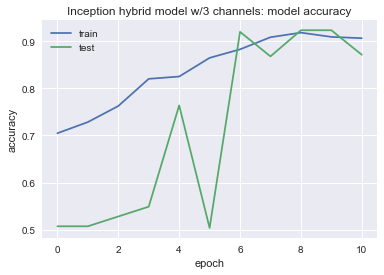

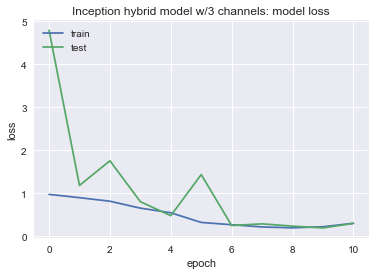

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
angle_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
sequential_154 (Sequential)      (None, 64)            694860                                       
____________________________________________________________________________________________________
sequential_155 (Sequential)      (None, 1)             6                                            
___________________________________________________________________________________________

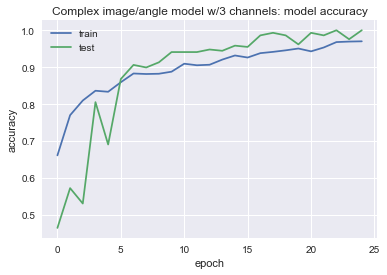

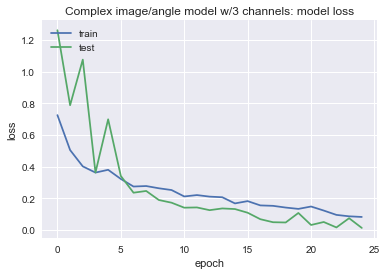

Done


In [116]:
#Train multi-input image/angle complex model
import os
try:
    random_seed = 42
    batch_size = 24
    epochs = 11
    os.system('say "And they are off and running!"')
        
    #Inception hybrid model
    callbacks = get_callbacks('saved_models/weights.best.from_image_angle_inception_hybrid_model_short_run.hdf5', 20)
    model = get_inception_hybrid_model()

    #Simple fit
    history = model.fit([X_train,angles], labels, 
          validation_data=([Image_valid,Angle_valid], image_valid_labels),
          epochs=epochs, batch_size=24, callbacks=callbacks, verbose=1)


    graph_model_performance('Inception hybrid model w/3 channels', history)

    epochs = 25
    
    #Complex image/angle model
    callbacks = get_callbacks('saved_models/weights.best.from_image_angle_complex_model_short_run.hdf5', 20)
    model = get_complex_model()

    #Simple fit
    history = model.fit([X_train,angles], labels, 
          validation_data=([Image_valid,Angle_valid], image_valid_labels),
          epochs=epochs, batch_size=24, callbacks=callbacks, verbose=1)


    graph_model_performance('Complex image/angle model w/3 channels', history)
        
    
    print("Done")
    os.system('say "Process has finished running.  Attitude is everything!"')
    os.system('say "Process has finished running.  Attitude is everything!"')
    os.system('say "Process has finished running.  Attitude is everything!"')
except:
    os.system('say "Just a moment.  Just a moment.  I just picked up a fault in the A E 35 Unit"')
    print("ERROR OCCURED!")
    raise

In [123]:
#Evaluate the model
print("Evaluating model...")
#model = get_baseline_analogy_model()
#model.load_weights(filepath='saved_models/weights.best.from_baseline_analogy_images_only_model.hdf5')
#score = model.evaluate(Image_valid, image_valid_labels, verbose=1)
model = get_complex_model()
#model.load_weights(filepath='saved_models/weights.best.from_image_angle_complex_model.hdf5')
model.load_weights(filepath='saved_models/weights.best.from_image_angle_complex_model_short_run.hdf5')
#model = get_inception_hybrid_model()
#model.load_weights(filepath='saved_models/weights.best.from_image_angle_inception_hybrid_model.hdf5')
#model.load_weights(filepath='saved_models/weights.best.from_image_angle_inception_hybrid_model_short_run.hdf5')
print("Best weights loaded...scoring...")
score = model.evaluate([Image_valid,Angle_valid], image_valid_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Evaluating model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
angle_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
sequential_168 (Sequential)      (None, 64)            694860                                       
____________________________________________________________________________________________________
sequential_169 (Sequential)      (None, 1)             6                                            
_______________________________________________________________________

In [124]:
#Produce a Kaggle Submission

print("Starting submission")
model = get_inception_hybrid_model()
#model.load_weights(filepath='saved_models/weights.best.from_image_angle_inception_hybrid_model.hdf5')
model.load_weights(filepath='saved_models/weights.best.from_image_angle_inception_hybrid_model_short_run.hdf5')

#model = get_complex_model()
#print(test['inc_angle'].head())
Incident_angle = test.inc_angle
#print(Incident_angle.head())
#Create dual band having HH and HV (i.e. tensor depth of 2)
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
#2 Channels
#X_test = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=-1)
#3 Channels
X_test = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
#print(X_test[0])
predicted_test=model.predict([X_test,Incident_angle], verbose=1)

submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

print("Done producing submission")

Starting submission
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2235 (Ba (None, 75, 75, 3)         12        
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 150, 150, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_60 (Flatten)         (None, 18432)             0         
Total params: 21,802,796.0
Trainable params: 21,768,358.0
Non-trainable params: 34,438.0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2330 (Ba (None, 1)                 4         
_________________________________

### Free-Form Visualization

Best weights loaded...scoring...
Actuals:  25     1
45     0
85     1
205    0
Name: is_iceberg, dtype: int64
4/4 [==============================] - 0s
Predictions:  [1.0, 0.0, 0.0, 1.0]
Sample iceberg image data (band_1)


<function matplotlib.pyplot.show>

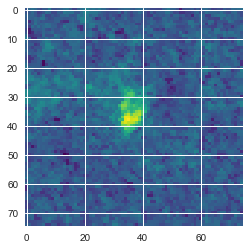

In [137]:
#model = get_complex_model()
#model.load_weights(filepath='saved_models/weights.best.from_image_angle_complex_model_short_run.hdf5')
print("Best weights loaded...scoring...")
index_list = [25,45,85,205]
print("Actuals: ", image_labels.ix[index_list])
results = model.predict([Image_train[index_list], Angle_train[index_list]], verbose=1)
results_rounded = [round(x[0]) for x in results]
print("Predictions: ", results_rounded)

#25 iceberg: correct
#45 ship: correct
#85 iceberg: incorrect
#205 ship: incorrect


print("Sample iceberg image data (band_1)")
iceberg_image_band_1 = icebergs.iloc[205]['band_1']
plt.imshow(np.reshape(np.array(iceberg_image_band_1),(75,75)), cmap=colormap)
plt.show

### Unsuccessful attempt to incorporate Grid Search Cross-Validation and Image Augmentation for better late fusion/Complex Merge & Inception Hybrid Model performance

In [80]:
#Attempts to get K-fold CV & Image Augmentation working together (especially in a multi-input model) 
#did not seem to work with the environments I could configure
#However, this is a highly recommended next step and there were indications on the web that this could
#be done with the latest TensorFlow version running on Ubuntu with GPUs

from keras.preprocessing.image import ImageDataGenerator 
idg = ImageDataGenerator(
    width_shift_range=0.0,  #Seems intuitive the image could shift width-wise
    height_shift_range=0.0, #Seems intuitive the image could shift height-wise
    zoom_range=0.0) #Seems intuitive the image could vary in zoom  (orbit apogee/perigee)

#Want to do K-fold Cross Validation AND image data augmentation, but ImageDataGenerator does not support synchronizing multiple input models
#Special thanks/credit to Devesh Maheshwari for sharing this ingenious solution on Kaggle
def gen_flow_for_two_inputs(image_data, angle_data, lables, batch_size, seed):
    #Produce images as ImageDataGenerator is intended to do
    image_data_generator = idg.flow(image_data,lables, batch_size=batch_size,seed=seed)
    #Treat angles as label data so that they're not transformed/augmented, but stay in synch with generated augmented images
    angle_data_generator = idg.flow(image_data,angle_data, batch_size=batch_size,seed=seed)
    while True:
            X1i = image_data_generator.next()
            X2i = angle_data_generator.next()
            yield [X1i[0], X2i[1]], X1i[1]
            
print("Done")

Done


Working fold:  0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
angle_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
sequential_94 (Sequential)       (None, 64)            694860                                       
____________________________________________________________________________________________________
sequential_95 (Sequential)       (None, 1)             6                                            
__________________________________________________________________________

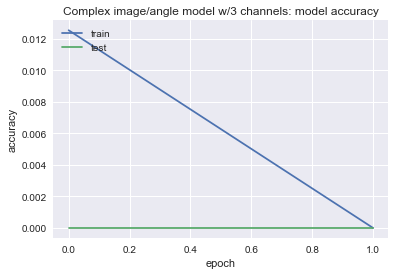

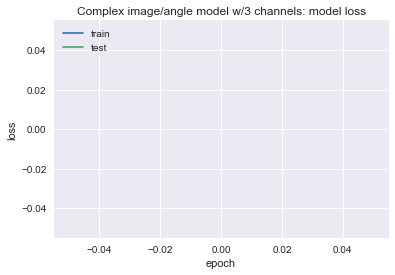

Working fold:  1
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
angle_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
sequential_97 (Sequential)       (None, 64)            694860                                       
____________________________________________________________________________________________________
sequential_98 (Sequential)       (None, 1)             6                                            
__________________________________________________________________________

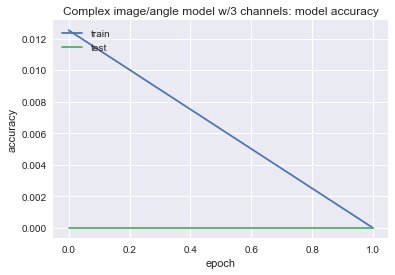

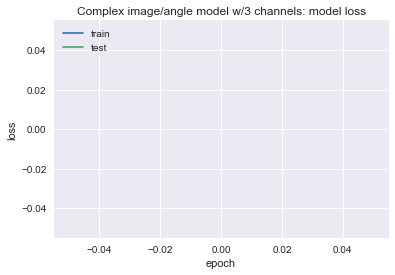

Working fold:  2
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
angle_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
sequential_100 (Sequential)      (None, 64)            694860                                       
____________________________________________________________________________________________________
sequential_101 (Sequential)      (None, 1)             6                                            
__________________________________________________________________________

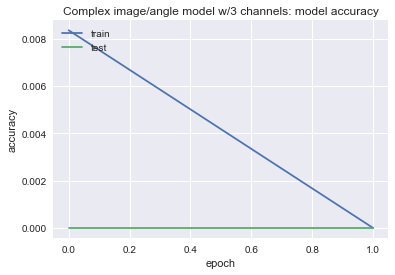

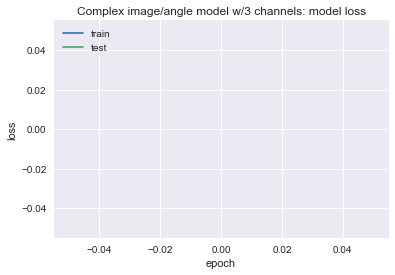

Done


In [65]:
#Attempt to train multiple-input models (complex & Inception) with both K-Fold CV & Image Augmentation
import os
try:
    random_seed = 42
    batch_size = 24
    epochs = 2
    os.system('say "And they are off and running!"')
    from sklearn.model_selection import StratifiedKFold
    kfolds = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed).split(X_train, labels))
    for fold, (train_index, valid_index) in enumerate(kfolds):
        print("Working fold: ", fold)
        image_train = X_train[train_index]
        labels_train = labels[train_index]
        image_valid = X_train[valid_index]
        labels_valid = labels[valid_index]
        angle_train = angles[train_index]
        angle_valid = angles[valid_index]
        
        #gen_flow = gen_flow_for_two_inputs(image_train, angle_train, labels_train, batch_size, random_seed)
        #print(gen_flow)
        
        #Inception hybrid model
        #callbacks = get_callbacks('saved_models/weights.best.from_image_angle_inception_hybrid_model.hdf5', 20)
        #model = get_inception_hybrid_model()
        
        #Complex image/angle model
        callbacks = get_callbacks('saved_models/weights.best.from_image_angle_complex_model.hdf5', 20)
        model = get_complex_model()
        
        #Simple fit
        """history = model.fit([X_train,angles], labels, 
              validation_split=0.2,
              epochs=2, batch_size=24, callbacks=callbacks, verbose=1)"""
              
        #K-fold CV (no image augmentation)
        history = model.fit([image_train,angle_train], labels_train, 
              validation_data=([image_valid,angle_valid], labels_valid),
              epochs=2, batch_size=24, callbacks=callbacks, verbose=1)
              
        #Full K-fold CV & Image Augmentation
        """history = model.fit_generator(
            gen_flow,
            steps_per_epoch=batch_size,
            epochs=epochs,
            #shuffle=True,
            verbose=1,
            validation_data=([image_valid,angle_valid], labels_valid),
            validation_steps=batch_size,
            callbacks=callbacks)"""
        
        graph_model_performance('Complex image/angle model w/3 channels', history)
        
    
    print("Done")
    os.system('say "Process has finished running.  Attitude is everything!"')
    os.system('say "Process has finished running.  Attitude is everything!"')
    os.system('say "Process has finished running.  Attitude is everything!"')
except:
    os.system('say "Just a moment.  Just a moment.  I just picked up a fault in the A E 35 Unit"')
    print("ERROR OCCURED!")
    raise